### Importing libs

In [19]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from heuristics.closest_neighbor import closest_neighbor
from typing import List, Dict, Set, Any, Tuple
from itertools import product
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#### Import data set

In [20]:
try:
    data_set = get_data_json("../../data/ReggioEmilia/4ReggioEmilia30.json")

    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 1
    Q = vehicle_capacity
    q = demands
    c = distance_matrix
except Exception as e:
    raise e

2024-09-09 09:19:31.194 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


#### Visualize the distance matrix as a DataFrame

In [21]:
df = pd.DataFrame(c)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,3700,4000,3900,4900,3900,4800,3800,4000,2600,4600,3800,3000,3500
1,4300,0,1300,300,2400,1200,1300,2600,1600,1200,1000,600,1400,800
2,4500,900,0,900,2100,900,1000,1900,1300,2100,700,1400,2200,500
3,4500,300,1300,0,2200,1200,1000,2500,1600,1500,700,800,1600,800
4,5500,2200,2600,2000,0,3100,1200,3600,3200,2500,1800,2000,2600,2700
5,3700,800,900,1100,2900,0,1800,1500,500,2000,1500,1300,1700,400
6,5300,1400,1800,1100,2000,2300,0,2700,2300,2200,900,1800,2400,1900
7,3500,2200,1700,2400,3600,1500,2400,0,1400,3000,2400,2600,2700,1800
8,4300,800,1100,1000,3100,1000,2000,1500,0,1600,1700,1200,1300,600
9,3300,1600,2600,1800,2300,2500,2200,3000,2700,0,2100,1200,800,2100


#### Creating model instance

In [22]:
model = mip.Model(sense=mip.MINIMIZE, solver_name=mip.CBC)

#### Define binary and continuous decision variables

In [23]:
x: Dict[Tuple[int, int], mip.Var] = {
    (i, j): model.add_var(name=f"x_{i}_{j}", var_type=mip.BINARY) for (i, j) in A
}
t = [model.add_var(name=f"t_{j}", var_type=mip.INTEGER) for j in V]

#### Set the objective function to minimize total distance

In [24]:
model.objective = mip.minimize(mip.xsum(cost * x[i, j] for (i, j), cost in A.items()))

#### Set the m-TSP essential constraints

In [25]:
model += mip.xsum(x[i, i] for i in V) == 0

for j in V - {0}:
    model += mip.xsum(x[i, j] for i in V) == 1  # Inflow
    model += mip.xsum(x[j, i] for i in V) == 1  # Outflow

model += mip.xsum(x[0, j] for j in V - {0}) <= m  # Vehicle limit

model += (
    mip.xsum(x[0, j] for j in V - {0}) - mip.xsum(x[j, 0] for j in V - {0}) == 0
)  # All vehicles used must return to depot

In [26]:
for j in V:
    model += t[j] >= max(0, q[j])
    model += t[j] <= min(Q, Q + q[j])

for i in V:
    for j in V - {0}:
        if i != j:
            M = min(Q, Q + q[j])
            model += t[j] >= t[i] + q[j] - M * (1 - x[i, j])

for i in V - {0}:
    for j in V:
        if i != j:
            M = min(Q, Q - q[j])
            model += t[i] >= t[j] - q[j] - M * (1 - x[(i, j)])

#### Generate an initial solution using closest neighbor heuristics

In [27]:
def generate_initial_solution(
    stations: Set[int],
    demands: List[int],
    distance_matrix: np.matrix,
    vehicle_capacity: int,
    x: Dict[Tuple[int, int], mip.Var],
) -> List[Tuple[mip.Var, int]]:
    depot = 0
    customers = list(stations - {depot})
    demand_dict = dict(enumerate(demands))
    routes = closest_neighbor(
        depot, customers, demand_dict, distance_matrix, vehicle_capacity
    )

    initial_solution: List[Tuple[mip.Var, int]] = []
    for route in routes:
        for i, j in zip(route, route[1:]):
            initial_solution.append((x[i, j], 1))

    return initial_solution

In [28]:
initial_solution = generate_initial_solution(V, q, c, Q, x)

#### Implement separation procedure for subtour elimination

In [29]:
class SeparationProcedure(mip.ConstrsGenerator):
    def __init__(
        self,
        V: Set[int],
        A: Dict[Tuple[int, int], Any],
        q: List[int],
        Q: int,
        x: Dict[Tuple[int, int], mip.Var],
    ):
        self.V = V
        self.A = A
        self.x = x
        self.q = q
        self.Q = Q

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        vertices = self.V
        cut_pool = mip.CutPool()
        depot = 0
        y = model.translate(self.x)

        G_prime = nx.DiGraph()
        G_prime.add_nodes_from(vertices)

        arcs_prime = [
            (i, j) for i, j in product(vertices, vertices) if i != j and y[i, j]
        ]

        for u, v in arcs_prime:
            G_prime.add_edge(u, v, capacity=y[u, v].x)

        for node in vertices - {depot}:
            flow_value, _ = nx.maximum_flow(G_prime, depot, node)

            if flow_value < 1:
                _, (S, _) = nx.minimum_cut(G_prime, depot, node)

                tour = [
                    (y[i, j], y[i, j].x)
                    for i, j in product(vertices, vertices)
                    if i != j and y[i, j] and i in S and j in S
                ]

                if sum(value for _, value in tour) >= (len(S) - 1) + 1e-4:
                    cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - 1
                    cut_pool.add(cut)

                total_demand = abs(sum(self.q[i] for i in S))
                min_vehicles = math.ceil(total_demand / self.Q)

                if min_vehicles < flow_value:
                    if (
                        sum(value for _, value in tour)
                        >= (len(S) - max(1, min_vehicles)) + 1e-4
                    ):
                        stronger_cut = mip.xsum(1 * var for var, _ in tour) <= len(
                            S
                        ) - max(1, min_vehicles)
                        cut_pool.add(stronger_cut)

        for cut in cut_pool.cuts:
            model += cut

In [30]:
model.start = initial_solution
model.cuts_generator = SeparationProcedure(V, A, q, Q, x)
model.optimize(max_seconds=1200)

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 340 (-55) rows, 195 (-15) columns and 1313 (-146) elements
Clp1000I sum of infeasibilities 2.1386e-05 - average 6.28999e-08, 156 fixed columns
Coin0506I Presolve 57 (-283) rows, 23 (-172) columns and 166 (-1147) elements
Clp0006I 0  Obj 12092.594 Primal inf 1.4947459e-05 (5) Dual inf 9.3048166e+12 (16)
Clp0029I End of values pass after 23 iterations
Clp0014I Perturbing problem by 0.001% of 3.2887921 - largest nonzero change 4.0714911e-05 ( 0.0013625531%) - largest zero change 1.7714741e-05
Clp0000I Optimal - objective value 12092.031
Clp0000I Optimal - objective value 12092.031
Coin0511I After Postsolve, objective 12092.031, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 12092.031 Dual inf 23387.356 (28)
Clp0014I Perturbing problem by 0.001% of 1.0181554 - largest nonzero change 1.9588059e-05 ( 0.00096358971%) - largest zero change 2.5735924e-05
Clp0000I Optimal - objecti

<OptimizationStatus.FEASIBLE: 3>

In [31]:
if model.num_solutions:
    selected_edges = [
        (origin, destination)
        for origin in V
        for destination in V
        if 0.5 <= x[origin, destination].x and x[origin, destination].x <= 1
    ]

    remaining_bikes = [t[station].x for station in range(len(t))]

    for origin, destination in selected_edges:
        edge_variable = model.var_by_name(f"x_{origin}_{destination}")
        edge_value = x[origin, destination].x
        print(f"{edge_variable} = {edge_value}")

x_0_7 = 1.0
x_1_11 = 1.0
x_2_10 = 1.0
x_3_1 = 1.0
x_4_6 = 1.0
x_5_8 = 1.0
x_6_3 = 1.0
x_7_5 = 1.0
x_8_13 = 1.0
x_9_12 = 1.0
x_10_4 = 1.0
x_11_9 = 1.0
x_12_0 = 1.0
x_13_2 = 1.0


In [32]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")


Initial demand at each station:
Station 0: 0
Station 1: -3
Station 2: 1
Station 3: 2
Station 4: -5
Station 5: 2
Station 6: -10
Station 7: -2
Station 8: -2
Station 9: 3
Station 10: -1
Station 11: -6
Station 12: -9
Station 13: 2


In [33]:
for station, balance in enumerate(remaining_bikes):
    print(f"Station {station} remaining bikes after visit: {balance}")

Station 0 remaining bikes after visit: 0.0
Station 1 remaining bikes after visit: 13.0
Station 2 remaining bikes after visit: 30.0
Station 3 remaining bikes after visit: 16.0
Station 4 remaining bikes after visit: 24.0
Station 5 remaining bikes after visit: 29.0
Station 6 remaining bikes after visit: 14.0
Station 7 remaining bikes after visit: 27.0
Station 8 remaining bikes after visit: 27.0
Station 9 remaining bikes after visit: 10.0
Station 10 remaining bikes after visit: 29.0
Station 11 remaining bikes after visit: 7.0
Station 12 remaining bikes after visit: 1.0
Station 13 remaining bikes after visit: 29.0


In [34]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

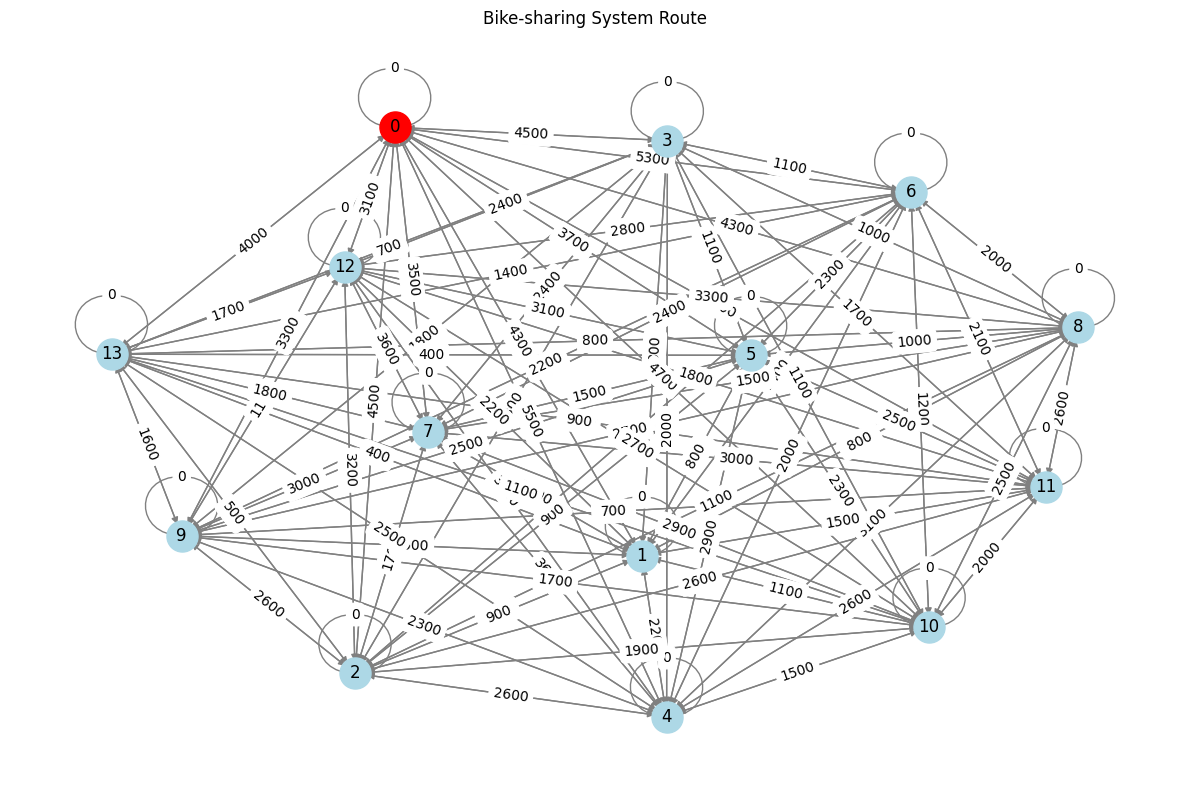

In [35]:
plot_route(V, A)

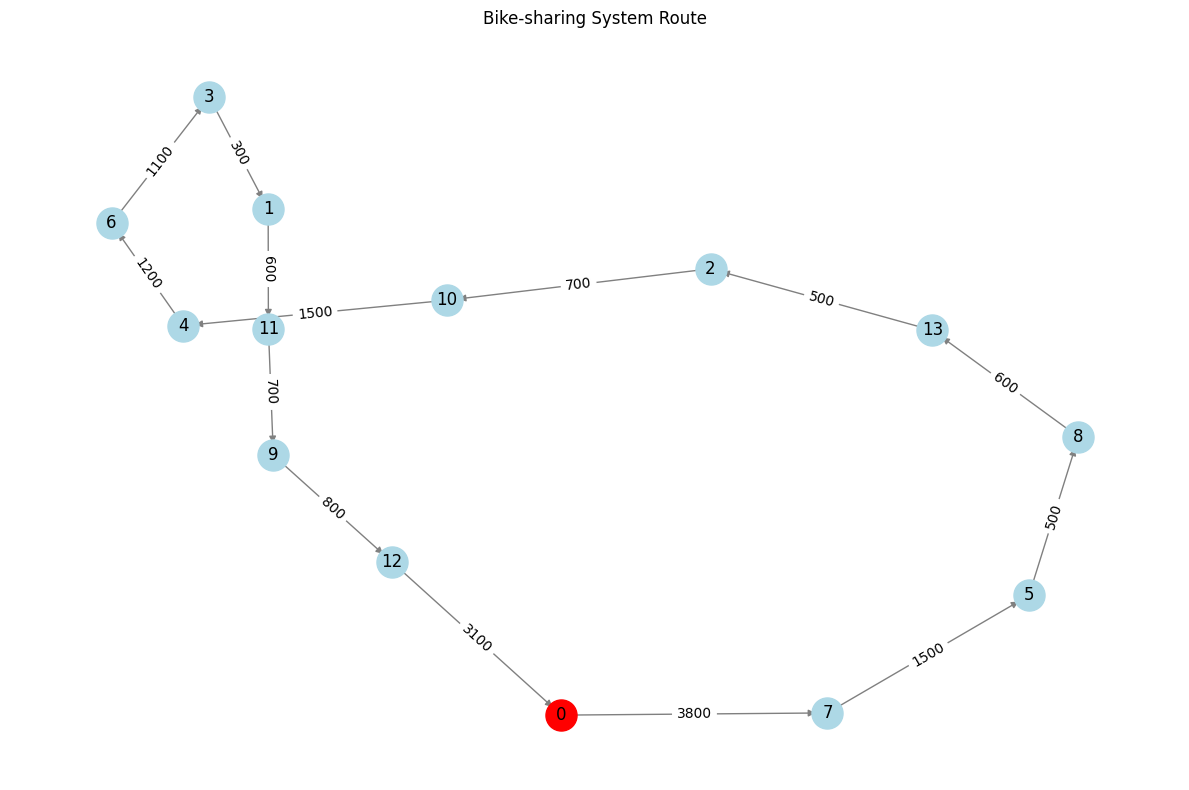

In [37]:
plot_route(V, selected_edges)